# The Game of Life, Inheritance, and Cellular Automata

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/inheritance_game_of_life.ipynb)

We start by importing the necessary Python packages.

<!--
*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

In [5]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


### Cellular Automata

Cellular automata are systems where all physical laws and fields are discretized: space is a lattice, time is discrete, and quantities like mass or spin are quantized. In these purely discrete universes, all physical laws take the form of IF-THEN statements.

The physical laws encoding the IF-THEN statements are called *update rules*. These rules are applied to each lattice site, and the result is a new state for the entire lattice. Typically, the update rules are *local*, meaning that the new state of a lattice site depends only on the state of the lattice site and its neighbors. Additionally, the update rules are *synchronous*, meaning that all sites are updated simultaneously. Basic cellular automata are usually also *Markovian*, meaning that the field values at the current time determine the field values at the next time, and so long-term memory does not exist outside of the current state of the system.

<!-- Certain board games, like checkers, become Markovian cellular automata when the game is played optimally, because [the optimal strategy](https://doi.org/10.1126/science.1144079) is a function only of the current state of the board. However, suboptimal play in games like chess or Go give rise to non-Markovian dynamics, because the optimal strategy depends on the history of the game and assessment of the opponent's likely moves. -->

### The Game of Life

Conway's Game of Life is a cellular automaton that was first introduced in 1970 by the mathematician John Conway. It is a simple yet powerful model that demonstrates the emergence of complex patterns from simple rules. The Game of Life is a Markovian, local, and synchronous cellular automaton. The update rule depends only on the nearest neighbors of each lattice site, and the field variable has only two possible values, 0 (dead) or 1 (alive). The rules are as follows:

1. Underpopulation: Any live cell with fewer than two live neighbours dies ($1 \rightarrow 0$)
2. Survival: Any live cell with two or three live neighbours lives stays alive ($1 \rightarrow 1$)
3. Overpopulation: Any live cell with more than three live neighbours dies ($1 \rightarrow 0$)
3. Reproduction: Any dead cell with *exactly* three live neighbours becomes a live cell ($0 \rightarrow 1$)

These simple rules give rise to surprisingly complex behaviors; in fact, the Game of Life has been shown to [support universal computation](https://doi.org/10.1007/978-3-319-19842-2_1), given a suitable encoding scheme based on initial conditions. Below shows some examples of fixed-point, limit-cycle, and soliton like dynamics.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/Gospers_glider_gun.gif" style="max-width:80%; height:auto;">

<br>

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/Game_of_life_beacon.gif" style="max-width:20%; height:auto;">
<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/Game_of_life_pulsar.gif" style="max-width:20%; height:auto;">
<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/Game_of_life_animated_LWSS.gif" style="max-width:20%; height:auto;">
<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/Game_of_life_animated_glider.gif" style="max-width:20%; height:auto;">

*Images from Scholarpedia*

# Implementing Cellular Automata using inheritance in Python

Because the Game of Life represents a specific case of the more general class of cellular automata, we will start by defining a "base" class for cellular automata, `CellularAutomaton`, and then define subclasses for various specific automata rulesets. The base class handles state counting, initialization, and will contain a `simulate` method for the simulation loop (where we repeatedly call the update rule).

In the base class, we will define a `next_state` method because the `simulate` method depends on it. But because the state rule is different for each automaton, we will leave the implementation of `next_state` to be overwritten by the subclasses (the base class raises an exception)
This convention is an example of the [Template Method Pattern](https://en.wikipedia.org/wiki/Template_method_pattern) in software development.


In [6]:
# A base allows us to impose structure on specific cases. We will use this as a parent
# for subsequent classes
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a
            random initial state is used.

    """
    def __init__(self, n, n_states, random_state=None, initial_state=None):
        self.n_states = n_states
        self.n = n
        self.random_state = random_state

        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=(self.n, self.n))
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        raise NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            self.history.append(self.state)
        return self.state

We can now check that our base class works as expected by instantiating a specific case of it.

Initialized a cellular automaton with 10 cells and 2 states


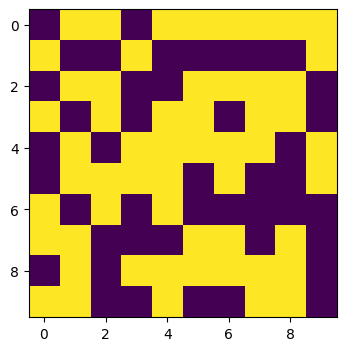

In [7]:
ca = CellularAutomaton(10, 2, random_state=0)
print(f"Initialized a cellular automaton with {ca.n} cells and {ca.n_states} states")

plt.figure(figsize=(4, 4))
plt.imshow(ca.initial_state)

However, the base class itself does not function, because the `next_state` method is not implemented.

In [8]:
# ca.simulate(10)

Before implementing the Game of Life, we will start by defining two simpler automata as subclasses of the base class. The  `ExtinctionAutomaton` sends every single input condition to the same output state ($0$), while the `RandomAutomaton` assigns each input state to either 0 or 1 randomly.

In [9]:
class ExtinctionAutomaton(CellularAutomaton):
    """
    A cellular automaton that simulates the extinction of a species.
    """
    def __init__(self, n, **kwargs):
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Output the next state of the entire board
        """
        next_state = np.zeros_like(self.state)
        return next_state


class RandomAutomaton(CellularAutomaton):
    """
    A cellular automaton with random updates
    """
    def __init__(self, n, random_state=None, **kwargs):
        np.random.seed(random_state)
        super().__init__(n, 2, **kwargs)
        self.random_state = random_state

    def next_state(self):
        """
        Output the next state of the entire board
        """
        next_state = np.random.choice(self.n_states, size=(self.n, self.n))
        return next_state

Let's try running these automata, to see how they work

Text(0.5, 1.0, 'Final state')

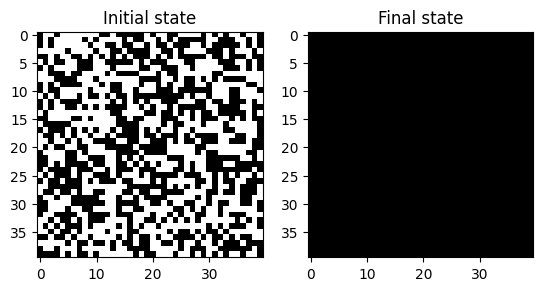

In [10]:
model = ExtinctionAutomaton(40, random_state=0)
model.simulate(200)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")
plt.subplot(1, 2, 2)
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

Text(0.5, 1.0, 'Final state')

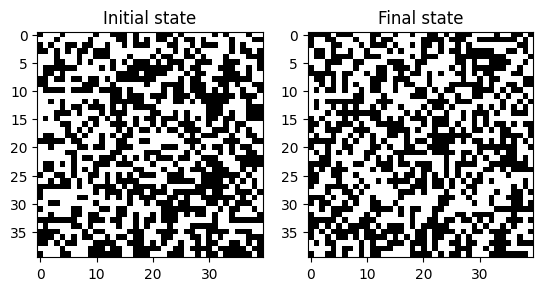

In [11]:
model = RandomAutomaton(40, random_state=0) ## Check random seed handling
model.simulate(200)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")
plt.subplot(1, 2, 2)
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

We are now ready to define the Game of Life as a subclass of the base class. In order to implement `next_state`, we will need to count the number of neighbors of each cell. We will do this by implementing three nested loops. The two outer loops will iterate over all the cells in the lattice, and the inner loop will iterate over the neighbors of the current cell. After counting the neighbors, we will apply the rules of the Game of Life to determine the next state of the cell.

For the innermost neighbor loop, we will use striding centered at the current cell position to extract the 3x3 neighborhood of the current cell. We don't need to explicitly handle boundary conditions, because the negative strides will automatically pull the values from the other side of the array, resulting in periodic boundary conditions.

After finding the neighbors, their sum is computed in order to find the number of live ($s=1$) neighbors, and the rules of the Game of Life are applied to determine the next state of the current cell:

1. Underpopulation: Any live cell with fewer than two live neighbours dies
2. Survival: Any live cell with two or three live neighbours lives stays alive
3. Overpopulation: Any live cell with more than three live neighbours dies
3. Reproduction: Any dead cell with *exactly* three live neighbours becomes a live cell


In [12]:

# This child class inherits methods from the parent class
class GameOfLife(CellularAutomaton):
    """
    An implementation of Conway's Game of Life in Python

    Args:
        n (int): The number of cells in the system
        **kwargs: Additional keyword arguments passed to the base CellularAutomaton class
    """

    def __init__(self, n, **kwargs):
        # the super method calls the parent class's __init__ method and passes the
        # arguments to it.
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Compute the next state of the lattice
        """
        # Compute the next state
        next_state = np.zeros_like(self.state) # preallocate the next state
        for i in range(self.n):
            for j in range(self.n):

                # Count the number of neighbors. Subtracting the center cell
                # ensures that we don't count the cell itself.
                n_neighbors = np.sum(
                    self.state[i - 1:i + 2, j - 1:j + 2]
                ) - self.state[i, j]

                # Update the next state using the rules of the Game of Life
                if self.state[i, j] == 1:
                    if n_neighbors in [2, 3]:
                        next_state[i, j] = 1
                    else:
                        next_state[i, j] = 0

                else:
                    if n_neighbors == 3:
                        next_state[i, j] = 1
                    else:
                        next_state[i, j] = 0
        return next_state

We can now run this automaton and see how it behaves. We will also try using the timing utility to see how long it takes to run the simulation for one step.

Average time per iteration: 7.86 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 1.0, 'Final state')

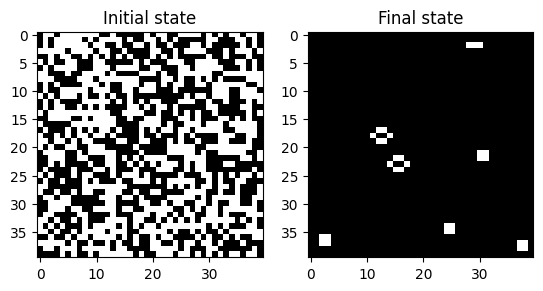

In [13]:
model = GameOfLife(40, random_state=0)
model.simulate(500)

# print timing results
print("Average time per iteration: ", end="")
%timeit model.next_state()

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")
plt.subplot(1, 2, 2)
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

Because our base class included a `history` attribute and a storage utility in the `simulate` method, we can also access the full time series of automaton states, which our base class stores in a list. We can use this to make animations, and to analyze the behavior of the automaton over time.

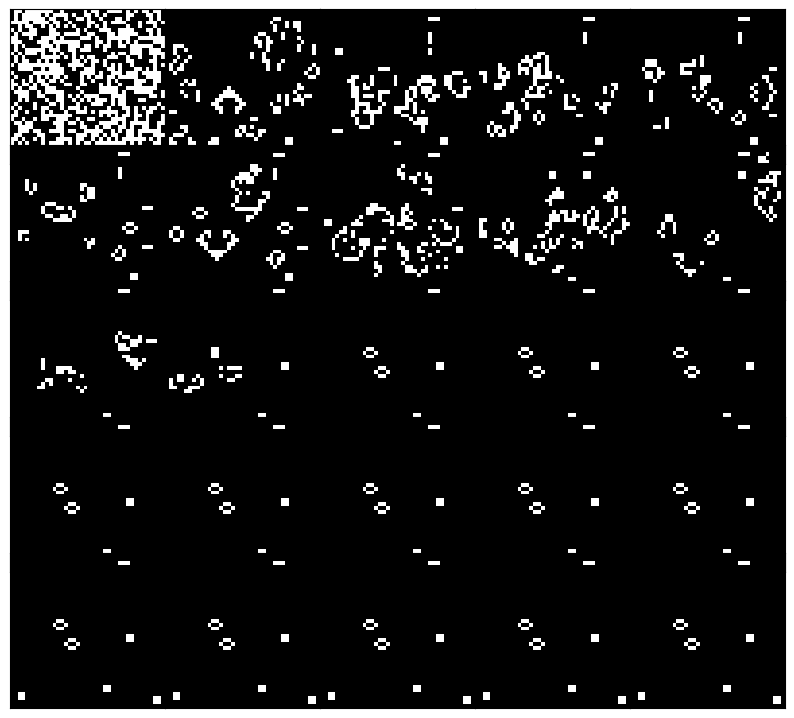

In [14]:
plt.figure(figsize=(10, 10))
### plot 25 equally spaced frames from the history
frames = model.history[::len(model.history) // 25][:-1]
for i, frame in enumerate(frames):
    plt.subplot(5, 5, i+1)
    plt.imshow(frame, cmap="gray")
    plt.xticks([]); plt.yticks([])
    ## minimize spacing between frames
    plt.subplots_adjust(wspace=0, hspace=-0.4)


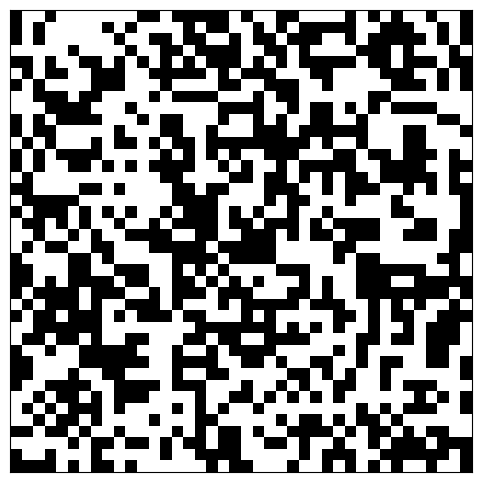

In [15]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy()

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=0, vmax=1, cmap="gray");
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=50)
HTML(ani.to_jshtml())

# How long did that take?

We can now estimate the expected runtime of our Game of Life simulation by estimating the number of operations required to update the entire lattice. We first need to define a measure of the problem size. In our case, we will set $N$ equal to the *total number of cells* in the lattice. So, for a $100 \times 100$ lattice, $N = 10000$. We choose this convention because the lattice could be non-square, or we may want to consider a 3D lattice, and so we need a consistent measure of the size that is invariant to the dimensionality of the lattice.

### Memory Scaling

When simulating the Game of Life, we need to store the entire lattice in memory, requiring at least $N$ values.  For synchronous update rules, each site value $s_{ij}(t+1)$ at timestep $t + 1$ depends on the lattice $s_{ij}(t)$. That means that each timestep requires a full copy of the entire universe, into which we write the next states one-by-one. Our implemention therefore writes new values of the lattice to a new array, which requires another $N$ values to be stored in memory. So, the total memory required is $2\,N$. Some array operations can be performed in-place using pass-by-reference tricks like pointers, in order to avoid this copying step, but our minimal implementation does not do this. So if our original lattice required 1 MP of memory, then we need to set aside 2 MP of memory to compute the next state. So-called "Big-O" notation usually ignores prefactors, and so we would say that the asymptotic space requirements to simulate the Game of Life are $\mathcal{O}(N)$.

### Runtime scaling

To assess the number of operations, or *time complexity*, of our algorithm, we need to look at what our algorithm does carefully. Since we update each lattice site once per iteration, we know that the complexity is at least $\mathcal{O}(N)$. The two outer loops therefore produce this cost. To compute the time complexity of the neighbor counting step, we need to poll the eight nearest neighbors of each site, requiring at least 9 operations to account for removing each site's own value from the sum. Implementing the Game of Life update rule requires a comparison of this sum against a set of cases followed by an update, which we will count as 1 operation per site. So each neighbor counting update takes about $10$ operations. For a more general cellular automaton that updates based on further neighbors (like next-nearest neighbors), this cost would increase.

We estimate that the overall runtime scales as $N \times K$. However, since $K \ll N$ we can treat it as a prefactor, and say that the runtime remains $\mathcal{O}(N)$. However, this is not always the case. If we had a global cellular automaton, like an N-body simulation, then each site's update might require computing pairwise forces between that site and all other sites.In this limit $K \sim N$ because we have to check every other site every time we update a single site. So a cellular automaton with global interactions would have runtime $\mathcal{O}(N^2)$

When implementing the Game of Life, the linear cost of both memory and runtime are due to the fact that we need to update every site. And so we suspect that we cannot improve the asymptotic scaling of the algorithm. However, low-level optimizations (vectorizations, convolution, etc) could stil decrease the runtime by reducing the prefactor. The Big-O scaling is thus an intrinsic mathematical property of an algorithm, and not a property of the hardware or software used to implement them.

## Can we improve our implementation?

A key idea of cellular automata is *locality*: the update of each site depends only on the state of its neighbors. The Game of Life uses a *Moore* neighborhood, in which the first nearest neighbors (including diagonals) are considered. The Game of Life update rule can therefore be seen as first implementing convolution of the grid state $f$ with a kernel $g$ of the form

$$
g \equiv
\begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

This discrete convolution essentially takes the sum of the neighbors, and uses this sum plus the state of the center cell in order to decide what to do. This makes the Game of Life an example of an *outer totalistic* cellular automaton. Recall that a two-dimensional discrete convolution has the form

$$
(f * g)(x, y) = \sum_{m=-\infty}^{\infty} \sum_{n=-\infty}^{\infty} f(x-m, y-n) g(m, n)
$$

However, when the kernel has compact support (as in our nearest-neighborhood update rule), this double summation simplifies,

$$
(f * g)(x, y) = \sum_{m=-K}^{K} \sum_{n=-K}^{K} f(x-m, y-n) g(m, n)
$$

For our Game of Life example, $K=1$. The periodic boundary conditions can be implemented by padding each dimension of $f$ with values from the other side of the array, and then cropping the convolution result to the original size of $f$. We can estimate the number of multiplications required to perform a discrete convolution by counting the number of elements in the kernel, $M$, and the number of elements in the grid, $N$, for an overall time complexity of $\mathcal{O}(M\,N)$.

([], [])

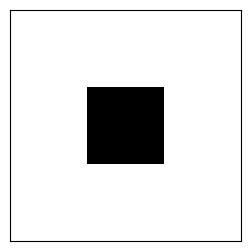

In [16]:
counting_kernel = np.ones((3, 3))
counting_kernel[1, 1] = 0

plt.figure(figsize=(3, 3))
plt.imshow(counting_kernel, cmap="gray")
plt.xticks([]); plt.yticks([])

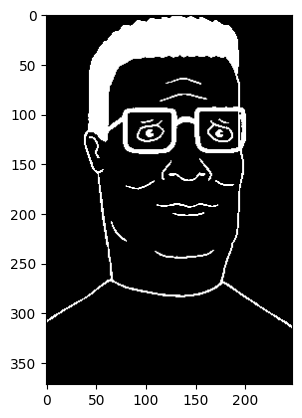

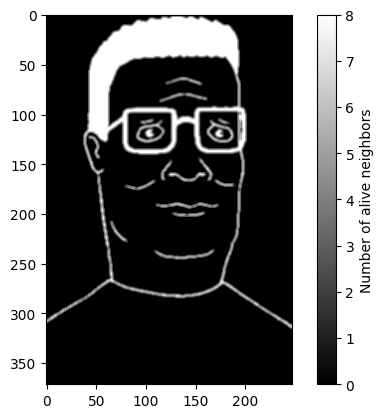

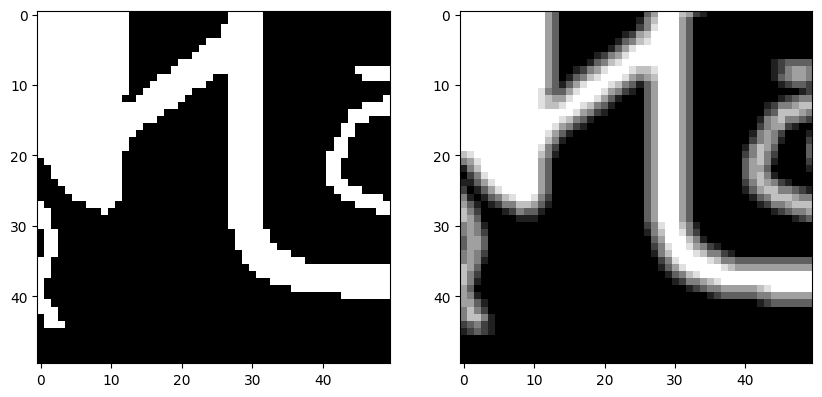

In [17]:
import requests
import numpy as np
import io

url = "https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/hank.npz"

response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses
image = np.load(io.BytesIO(response.content), allow_pickle=True)

## Convert to binary (0 and 1)
image_bw = (image < 0.5).astype(float)
plt.figure()
plt.imshow(image_bw, cmap="gray")


from scipy.signal import convolve2d
image_counts = convolve2d(image_bw, counting_kernel, mode='same', boundary='wrap')
plt.figure()
plt.imshow(image_counts, cmap="gray")
plt.colorbar(label="Number of alive neighbors")



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_bw[100:150, 50:100], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(image_counts[100:150, 50:100], cmap="gray")

Average time per iteration: 127 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


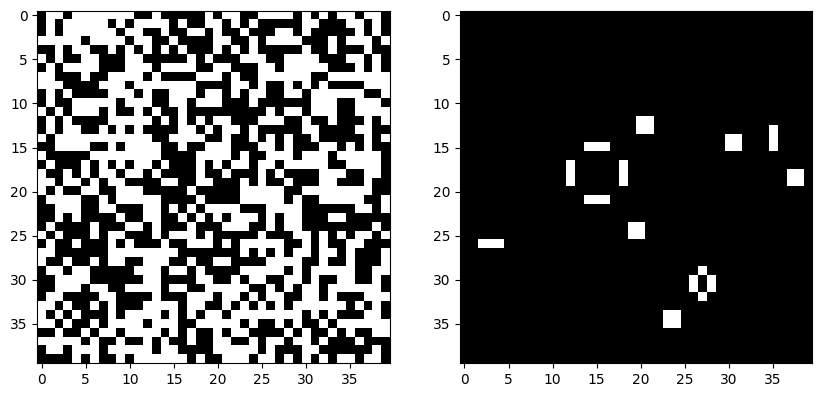

In [18]:

from scipy.signal import convolve2d

class GameOfLife(CellularAutomaton):

    def __init__(self, n, **kwargs):
        # the super method calls the parent class's __init__ method
        # and passes the arguments to it. It is a constructor
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Compute the next state of the lattice using discrete convolutions to implement
        the rules of the Game of Life.
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)

        # Compute the number of neighbors for each cell
        totalistic_kernel = np.ones((3, 3))
        totalistic_kernel[1, 1] = 0 # don't count the center cell itself

        # convolve with periodic boundary conditions
        n_neighbors = convolve2d(self.state, totalistic_kernel, mode='same', boundary='wrap')

        # implement the rules of the Game of Life in a vectorized way
        next_state = np.logical_or(
            np.logical_and(self.state == 1, n_neighbors == 2),
            n_neighbors == 3
        )

        return next_state

model = GameOfLife(40, random_state=0)
model.simulate(200)

print("Average time per iteration: ", end="")
%timeit model.next_state()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.initial_state, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(model.state, cmap="gray")

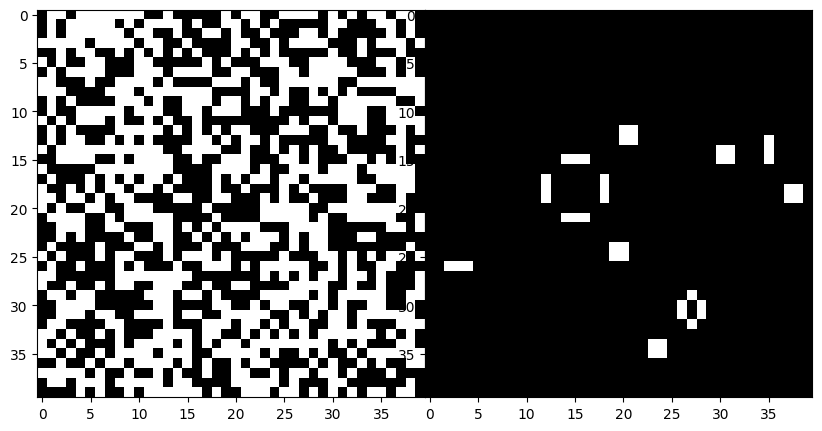

In [19]:
# model = GameOfLife(40, random_state=0, initial_state=image_bw.astype(int))
# model.simulate(400)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(model.initial_state, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(model.state, cmap="gray")
## horizontal spacing
plt.subplots_adjust(wspace=0, hspace=-10)

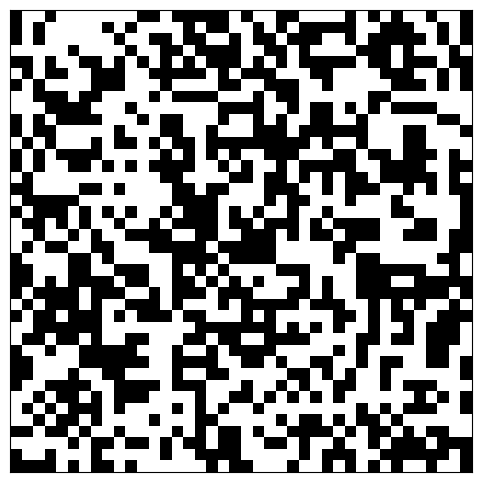

In [20]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy()

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=0, vmax=1, cmap="gray");
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=50)
HTML(ani.to_jshtml())

### Can we go even faster?

Based on the discrete convolution equation, we estimate that the runtime of a single update step is proportional to both the Moore neighborhood size and the total size of the grid, $\mathcal{O}(M\,N)$. Because the update rule is local, however, $M/N \ll 1$ and so the runtime is dominated by the factor $\mathcal{O}(N)$.

It turns out that we can speed up the convolution operation slightly by performing it in frequency space. Recall the equivalence between convolution and multiplication in the Fourier domain:

$$
\mathcal{F}\{f * g\} = \mathcal{F}\{f\} \cdot \mathcal{F}\{g\}
$$

where $\mathcal{F}$ is the Fourier transform operator. This means that we can compute the convolution of two functions by multiplying their Fourier transforms and then taking the inverse Fourier transform of the result. Since the product is taken elementwise over the transformed array and kernel, we expect the product to require $\mathcal{O}(N)$ multiplication operations, but we gain the cost of performing and inverting the Fourier transform. The Fourier Transform integral in two dimensions has the form

$$
\mathcal{F}\{f(x,y)\} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x,y) e^{-i\,k_x\,x} e^{-i\,k_y\,y} dx\,dy
$$

where $k_x$ and $k_y$ are the spatial frequencies in the $x$ and $y$ directions, respectively. This integral takes $\mathcal{O}(N^2)$ operations to compute, but it turns out that we can compute the Fourier transform in $\mathcal{O}(N\,\log N)$ operations using the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm.

While the asymptotic (and thus intrinsic) complexities are the same for convolutions in real and frequency space, the Fourier approach often has smaller prefactors and enables parallelization. In fact, many 2D convolution functions in modern languages use the FFT under the hood to speed up the computation.

# Extending the Game of Life to a continuous domain

We saw that the update rule for the game of life is a function of the number of neighbors of a cell. We can replace the discrete neighbor kernel with a continuous one. This idea is extended and refined in [Lenia](https://doi.org/10.25088/ComplexSystems.28.3.251), a fully continuous-time and continuous-space cellular automaton that exhibits surprisingly complex, life-like behavior. The following code is a highly-simplified version of Lenia.

Our neighbor counting kernel essentially consists of convolving the entire lattice with a square $3\times3$ kernel. We can replace this "hard" kernel with a donut-shaped kernel, which will add up the counts of neighbors within a certain radius of the center cell.

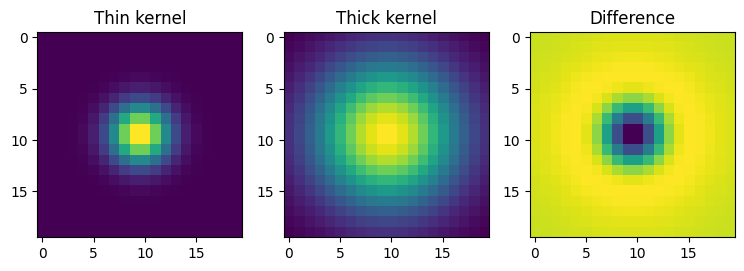

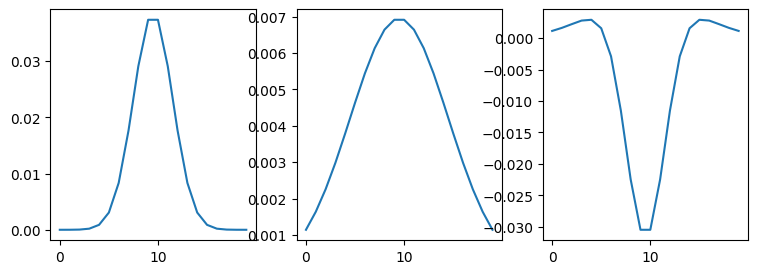

In [21]:
# We can use type hints to indicate the types of the arguments and return values
# of functions. This is not enforced by Python, but it can be useful for
# documentation and for static type checkers like mypy or numba
def gaussian_kernel(size: int, sigma: float):
    """
    Make a gaussian kernel of given size and standard deviation.

    Args:
        size (int): the size of the kernel
        sigma (float): the standard deviation of the gaussian

    Returns:
        ndarray: the gaussian kernel
    """
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma**2)) *
                     np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

kernel1 = gaussian_kernel(20, 2)
kernel2 = gaussian_kernel(20, 5)

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(kernel1, cmap="viridis")
plt.title("Thin kernel")
plt.subplot(1, 3, 2)
plt.imshow(kernel2, cmap="viridis")
plt.title("Thick kernel")
plt.subplot(1, 3, 3)
plt.imshow(kernel2 - kernel1, cmap="viridis")
plt.title("Difference")

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.plot(kernel1[10, :])
plt.subplot(1, 3, 2)
plt.plot(kernel2[10, :])
plt.subplot(1, 3, 3)
plt.plot((kernel2 - kernel1)[10, :])




How do we count states? After performing the neighbor counting convolution, we can take each pixel's "count" value, which is now a continuous value, and we can apply smoother version of the Game of Life threshold logitc to it to determine the output state of the pixel. We will use a 1d Gaussian function:

$$
\text{state} \propto e^{-\frac{(x_i - \mu)^2}{2\sigma^2}}
$$

where $x_i$ is the count value at a given pixel. The parameter $\mu$ sets the target threshold---the output state will be largest if the pixel is closer to $\mu$. For example, if we want the output response to be maximized when the neighbor count is 3, we set $\mu = 3$. The parameter $\sigma$ sets the width of the Gaussian, and determines how quickly the output state falls off as the count value moves away from $\mu$. A count much less than $\mu$ corresponds to undercrowding, and a count much greater than $\mu$ corresponds to overcrowding.

We expect that setting $\sigma \approx 1$ will give us a sharp transition between counts that differ by 1, just like the discrete Game of Life responds very differently to 2 and 3 neighbors.

In [22]:
# from scipy.stats import multivariate_normal
from scipy.signal import convolve2d

def gaussian1d(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2))/(sigma * np.sqrt(2 * np.pi))

class SmoothGameOfLife(CellularAutomaton):
    """
    A class for the Game of Life on a continuous-valued lattice, based on the
    Lenia model.

    Parameters:
        n (int): the size of the lattice
        r (float): the standard deviation of the gaussian kernel

    References:
    Lenia: Lenia: Biology of Artificial Life by Bert Wang-Chak Chan
    https://doi.org/10.25088/ComplexSystems.28.3.251
    Lenia tutorial:
    https://colab.research.google.com/github/OpenLenia/Lenia-Tutorial/blob/main/Tutorial_From_Conway_to_Lenia.ipynb

    """
    def __init__(self, n, r=1, **kwargs):
        # the super method calls the parent class's __init__ method
        # and passes the arguments to it. It is a constructor
        super().__init__(n, 2, **kwargs)
        self.r = r

    def next_state(self):
        """
        Compute the next state of the lattice using discrete convolutions to implement
        the rules of the Game of Life.
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)

        # Make a gaussian convolutional kernel of 10 x 10 size
        # with standard deviation 1
        neighbors_kernel = gaussian_kernel(20, self.r)
        neighbors_kernel /= np.max(neighbors_kernel)
        self_kernel = gaussian_kernel(20, 2)
        self_kernel /= np.max(self_kernel)
        totalistic_kernel = neighbors_kernel - self_kernel
        totalistic_kernel /= np.sum(totalistic_kernel)

        # convolve with periodic boundary conditions
        n_neighbors = convolve2d(self.state, totalistic_kernel, mode='same', boundary='wrap')

        # Apply a nonlinearity elementwise to the neighbor count. This operates in a
        # pixelwise fashion, so we can vectorize it
        n_neighbors3 = gaussian1d(n_neighbors, 3, 0.5) # 3ish neighbors
        n_neighbors3 /= np.max(n_neighbors3) # normalize
        n_neighbors2 = gaussian1d(n_neighbors, 2, 0.4) # 2ish neighbors
        n_neighbors2 /= np.max(n_neighbors2) # normalize

        next_state = gaussian1d(self.state * n_neighbors2 + n_neighbors3, 1, 0.9)
        # next_state = gaussian1d(self.state * n_neighbors2 + n_neighbors3, 1, 1.1)
        next_state /= np.max(next_state)

        return next_state

Average time per iteration: 140 ms ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5, 1.0, 'Final state')

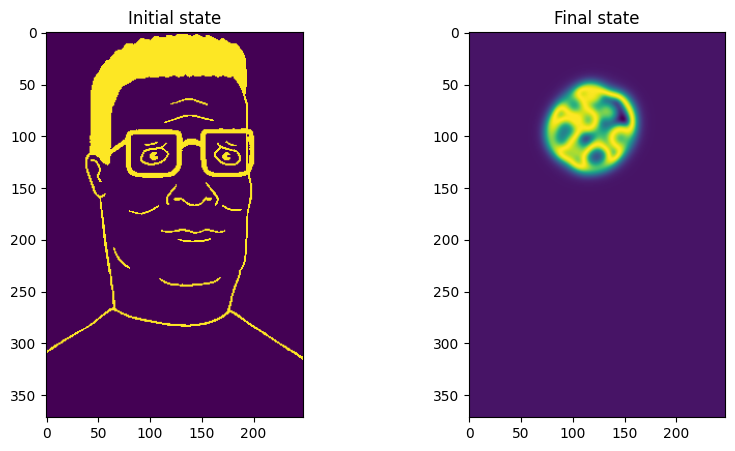

In [23]:
# model = SmoothGameOfLife(200, 5, random_state=0)
model = SmoothGameOfLife(200, 5, initial_state=image_bw.astype(float))
model.simulate(100)

print("Average time per iteration: ", end="")
%timeit model.next_state()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.initial_state, cmap="viridis")
plt.title("Initial state")
plt.subplot(1, 2, 2)
plt.imshow(model.state, cmap="viridis")
plt.title("Final state")

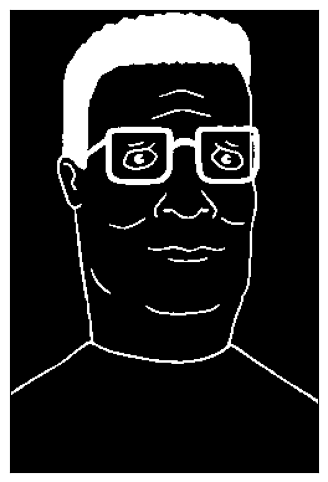

In [24]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = np.array(model.history).copy()

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=0, vmax=1, cmap="gray");
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
    img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=50)
HTML(ani.to_jshtml())

# Cellular automata as physical systems

Cellular automata represent an intriguing example of a physical system where surprising complexity can emerge from relatively simple rules. As a result, they have a rich history in the physics literature, although their usage has limitations due to a lack of analytical tools for working with their governing equations. Since all fields are discrete, we cannot use stability analysis or other common theoretical tools from physics to understand their behavior. One well-studied phenomenon in CA is the general classes of rules that produce rich behaviors like the Game of Life. For example, rules that send all cells to one or zero both produce trivial dynamics, and, extending this intuition, it turns out that rules that send roughly even numbers of states to one or zero tend to produce richer dynamics.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/eoc_ce_lambda.png" style="max-width:50%; height:auto;">

*Complexity of CA dynamics vs the entropy of the rule table. Image from [Langton, 1990](https://doi.org/10.1016/0167-2789(90)90064-V)*

Few real-world physical systems readily map onto cellular automata, because the physical world is usually continuous and often non-local. Additionally, few real-world systems have a *synchronous* update rule: all of the cells update to a new state at the same time: the value of a cell $x_{ij}(t+1)$ depends on the "frozen" values $x_{ij}(t)$ and its neighbors at the same instant $t$. Most real world systems instead require updates that are asynchronous: different cells can update at different times.

However, there a few systems that are approximately described by cellular automata. For example, [the scale patterning of lizard skin is well described by a cellular automaton](https://doi.org/10.1038/nature22031). The scales are separated by barriers that inhibit transport of signaling molecules that allowing neighboring scales to influence patterning, which effectively discretizes the spatial domain. Additionally, the timescale of the pattern evolving is extremely slow, and so synchronous update rules are approximately valid.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/41586_2017_Article_BFnature22031_Fig1_HTML.jpg" style="max-width:70%; height:auto;">

*Scale patterning in lizards. Image from [Manukyan et al. (2017)](https://doi.org/10.1038/nature22031)*

# Appendix

FileNotFoundError: [Errno 2] No such file or directory: '../private_dump/life/frame0000.png'

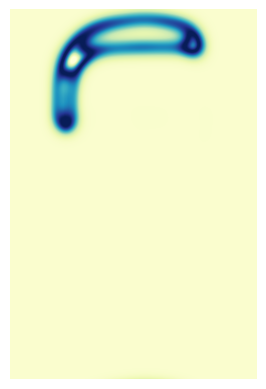

In [25]:


frames = model.history[4:]

vmin, vmax = np.percentile(frames, 1), np.percentile(frames, 99)
for i in range(len(frames) - 1):


    out_path = "../private_dump/life/frame" + str(i).zfill(4) + ".png"

    plt.figure()
    plt.imshow(frames[i], vmin=vmin, vmax=vmax, cmap="YlGnBu")

    ## Remove plot axes and other annotations
    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')
    # plt.gca().set_axis_off()
    # plt.gca().gca.xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().gca.yaxis.set_major_locator(plt.NullLocator())

    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.close()


In [ ]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(model.history[i], vmin=0, vmax=1, cmap="gray")
    plt.show()

interact(
    plotter,
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)